In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
data = pd.read_csv('../data_cleaned.csv')

In [3]:
data.head()

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3,Electronics,unemployment_rate,is_holiday_week
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,716.285714,0.0,0.368029,1,0,0,0,63,7.0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,716.428571,0.0,0.360911,1,0,0,0,54,7.0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,717.000000,0.0,0.344832,1,1,0,0,54,7.0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,717.000000,0.0,0.356973,1,1,0,0,45,7.0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,717.000000,0.0,0.359990,0,1,0,0,52,7.0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wk_strt_dt         209 non-null    object 
 1   yr_nbr             209 non-null    int64  
 2   qtr_nbr            209 non-null    int64  
 3   prd                209 non-null    int64  
 4   wk_nbr             209 non-null    int64  
 5   wk_in_yr_nbr       209 non-null    int64  
 6   mdip_dm            209 non-null    int64  
 7   mdip_inst          209 non-null    int64  
 8   mdip_nsp           209 non-null    int64  
 9   mdip_auddig        209 non-null    int64  
 10  mdip_audtr         209 non-null    int64  
 11  mdip_vidtr         209 non-null    int64  
 12  mdip_viddig        209 non-null    int64  
 13  mdip_so            209 non-null    int64  
 14  mdip_on            209 non-null    int64  
 15  mdip_em            209 non-null    int64  
 16  mdip_sms           209 non

In [5]:
data['wk_strt_dt'] = pd.to_datetime(data['wk_strt_dt'])

In [6]:
# Sklearn
from sklearn.model_selection import train_test_split

# Basic Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['wk_strt_dt','sales'],axis=1), data['sales'], random_state = 42)

In [8]:
# Baseline Model with vanilla Decision Tree

dt = DecisionTreeRegressor(random_state=101)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=101, splitter='best')

In [11]:
y_pred_test = dt.predict(X_test)

In [12]:
y_pred_train = dt.predict(X_train)

In [13]:
# Metrics
from sklearn.metrics import r2_score, mean_squared_error

In [18]:
# Decision trees are overfit, so getting to R^2 = 1 and MSE = 0  is possible in most cases

print(f'Train R^2-Score: {r2_score(y_train,y_pred_train)}')
print(f'Train Mean Squared Error: {mean_squared_error(y_train,y_pred_train)}')

Train R^2-Score: 1.0
Train Mean Squared Error: 0.0


In [19]:
print(f'Test R^2-Score: {r2_score(y_test,y_pred_test)}')
print(f'Test Mean Squared Error: {mean_squared_error(y_test,y_pred_test)}')

Test R^2-Score: -0.4632865120106857
Test Mean Squared Error: 3189290666913954.0


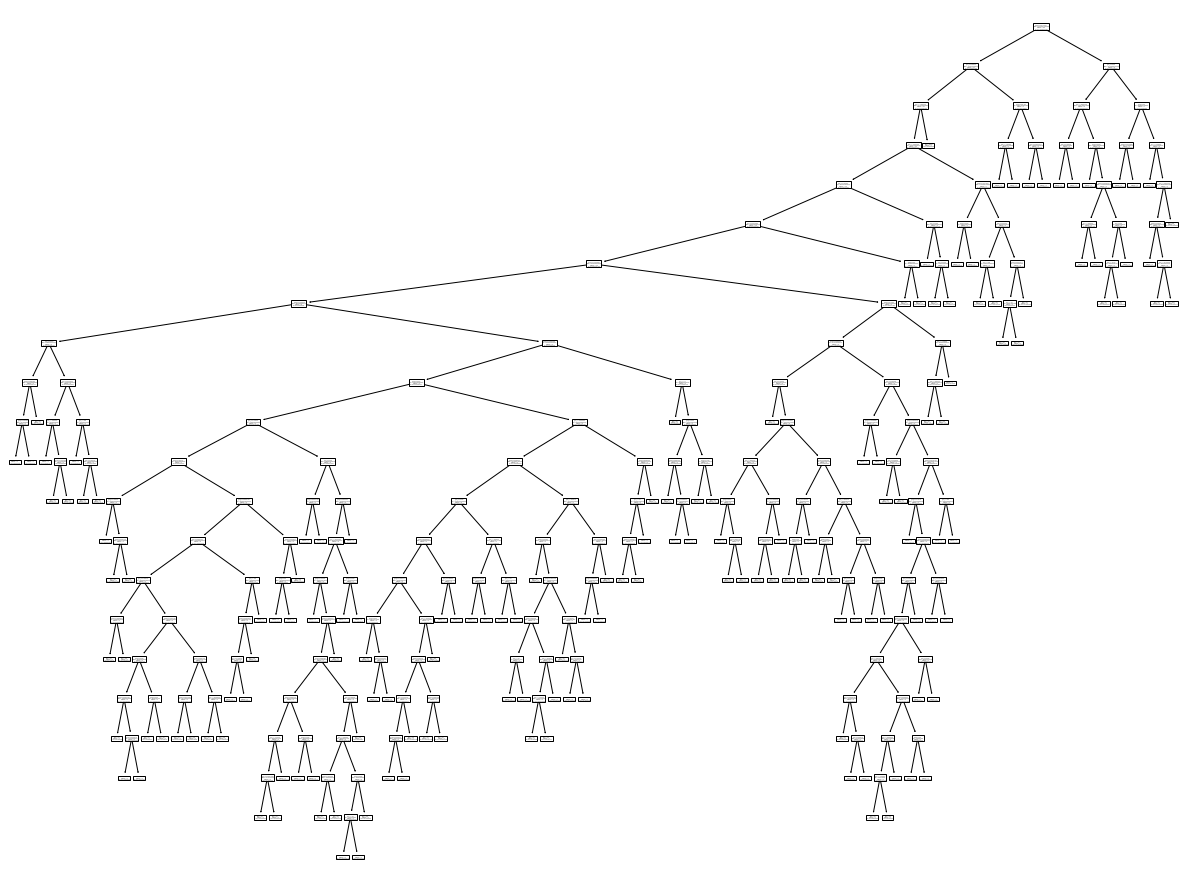

In [20]:
plt.figure(figsize=(21,16))

plot_tree(dt);
plt.show()

## Pystan

In [21]:
import pystan

In [22]:
# Same as in `understanding_pystan` notebook, 
# but includes QR decomposition

model = """
data {
    int<lower=0> N; // Number of training observations
    int<lower=0> K; // Number of predictors - ` (interecept)
    matrix[N, K] x; // Matrix of predictors
    vector[N] y_obs; // Training sales quantity
    
    int<lower=1> N_new; // Predictions
    matrix[N_new, K] x_new; 
}

parameters {
    real alpha; // intercept
    vector[K] beta; // coefficients 
    real<lower=0> sigma; // error scale
    
    vector[N_new] y_new;
}

transformed parameters {
    vector[N] theta;
    theta = alpha  + x * beta;
}

model {
    sigma ~ exponential(1);
    alpha ~ normal(0, 1);
    beta ~ multi_normal(rep_vector(0, K),
    diag_matrix(rep_vector(1,K)));
    
    y_obs ~ normal(theta, sigma); // likelihood
    
    y_new ~ normal(alpha + x_new * beta, sigma); // prediction model
}
"""

In [42]:
# Model Saved as Pickle, so only run this cell once
# Put data in a dictionary
data = {'N' : X_train.shape[0],
        'N_new' : X_test.shape[0],
        'K' : X_train.shape[1],
        'y_obs' : y_train.values.tolist(),
        'x' : np.array(X_train),
        'x_new' : np.array(X_test)}

# Compile model
sm = pystan.StanModel(model_code = model)

# Train model and generate samples
fit = sm.sampling(data=data, 
                 iter=4000, 
                 chains=8, 
                 warmup=500,
                 thin=1,
                 seed=101)

# Save fitted model
with open('bayes_advertising.pkl', 'wb') as f:
    pickle.dump([sm, fit], f, protocol = pickle.HIGHEST_PROTOCOL)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_874d81f150080fbcd26fd9c408087399 NOW.
C:\Users\gabri\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


In [43]:
# Load fitted model
with open('bayes_advertising.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# Extract and print the output of our model
fit = data_dict[1]
print(fit.stansummary())

Inference for Stan model: anon_model_874d81f150080fbcd26fd9c408087399.
8 chains, each with iter=4000; warmup=500; thin=1; 
post-warmup draws per chain=3500, total post-warmup draws=28000.

              mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
alpha       6.9e-3  5.8e-3   0.99  -1.93  -0.65    0.01   0.68   1.92  28669    1.0
beta[1]       1.54    0.04   1.03  -0.48   0.84    1.55   2.24   3.57    562   1.01
beta[2]       0.02  6.0e-3   1.01  -1.98  -0.67    0.02    0.7   1.99  28528    1.0
beta[3]    -7.2e-4  5.9e-3   0.99  -1.96  -0.67 -7.2e-4   0.66   1.94  28420    1.0
beta[4]     4.9e-3  5.7e-3    1.0  -1.94  -0.67  4.1e-3   0.67   1.95  30224    1.0
beta[5]     4.5e-3  5.7e-3    1.0  -1.96  -0.67  4.5e-3   0.68   1.99  30472    1.0
beta[6]       0.59     0.2   0.49   0.27   0.29     0.3   0.65   1.77      6   2.24
beta[7]      -0.22    0.04   0.15  -0.63  -0.27   -0.16  -0.15  -0.02     14   1.71
beta[8]       6.67    0.42   1.06   3.78   6.64    6.86

In [15]:
dff = pd.DataFrame({'y_pred':la['y_new'].mean(0), 'y_obs':y_test})

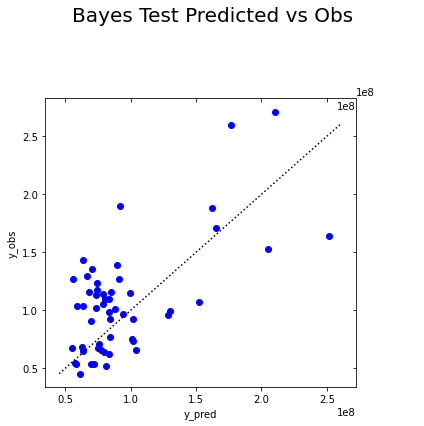

In [24]:
grid = sns.JointGrid(dff.y_pred, dff.y_obs, space=0)
grid.plot_joint(plt.scatter, color="b")
x0, x1 = grid.ax_joint.get_xlim()
y0, y1 = grid.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
grid.ax_joint.plot(lims, lims, ':k')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Bayes Test Predicted vs Obs',fontsize=20)
plt.show()

In [21]:
dff['y_pred'].mean(0)

94189561.15478106

In [25]:
r2_score(dff.iloc[:,1],dff.iloc[:,0])

0.28380883960954895

In [36]:
normalized_mutual_info_score(dff.iloc[:,1],dff.iloc[:,0])

1.0